In [98]:
import os, time
from scipy import stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
%matplotlib inline

from IPython.display import display, HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [99]:
# Create timestamp to show when this summary was run
print 'Summary run: ' + time.strftime("%a, %d %b %Y %H:%M")

Summary run: Thu, 02 Jul 2020 08:57


In [100]:
base_path = os.getcwd().split('\\scripts')[0]
relative_path = '../../../outputs'
pd.options.display.float_format = '{:,.3f}'.format
format_percent = "{:,.2%}".format

# Workers by County

In [101]:
df_wfh = pd.read_csv(os.path.join(relative_path,'agg','wfh_county.csv'))
df_wfh_survey = pd.read_csv(os.path.join(relative_path,'agg','survey','wfh_county.csv'))

# Total Workers by County
df_tot = pd.read_csv(os.path.join(relative_path,'agg','pptyp_county.csv'))
df_tot = df_tot[df_tot['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df_tot = df_tot.groupby('person_county').sum()[['psexpfac']].reset_index()

df_tot_survey = pd.read_csv(os.path.join(relative_path,'agg','survey','pptyp_county.csv'))
df_tot_survey = df_tot_survey[df_tot_survey['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df_tot_survey = df_tot_survey.groupby('person_county').sum()[['psexpfac']].reset_index()


df = df_wfh.merge(df_tot, on='person_county')
df.index = df['person_county']
df.drop('person_county', axis=1,inplace=True)
df.columns = ['WFH Workers', 'Total Workers']
df.loc['Region'] = df.sum(axis=0)
df['% WFH Workers'] = df['WFH Workers']/df['Total Workers']
df

,WFH Workers,Total Workers,% WFH Workers
person_county,,,
King,51307,1460329,0.035
Kitsap,8261,152452,0.054
Pierce,20999,533213,0.039
Snohomish,21915,561695,0.039
Region,102482,2707689,0.038


# Tour Rate for Work-at-Home Workers

In [102]:
df_tours = pd.read_csv(os.path.join(relative_path,'agg','work_from_home_tours.csv'))
total_wfh_workers = df_wfh.psexpfac.sum()
df = df_tours.groupby('pdpurp').sum()[['toexpfac']].reset_index()
df['tour_rate'] = df['toexpfac']/total_wfh_workers
df

df_tours_survey = pd.read_csv(os.path.join(relative_path,'agg','survey','work_from_home_tours.csv'))
total_wfh_workers_survey = df_wfh.psexpfac.sum()
df_survey = df_tours_survey.groupby('pdpurp').sum()[['toexpfac']].reset_index()
df_survey['tour_rate'] = df_survey['toexpfac']/total_wfh_workers_survey
df = df.merge(df_survey,on='pdpurp',suffixes=['_model','_survey'])
df.rename(columns={'toexpfac_model': 'tours_model', 'toexpfac_survey': 'tours_survey'}, inplace=True)
df['tours_survey'] = df['tours_survey'].astype('int')
df[['pdpurp','tours_model','tours_survey','tour_rate_model','tour_rate_survey']]

,pdpurp,tours_model,tours_survey,tour_rate_model,tour_rate_survey
0,Escort,15835,23855,0.155,0.233
1,Meal,5363,13909,0.052,0.136
2,Personal Business,15830,37415,0.154,0.365
3,School,5468,675,0.053,0.007
4,Shop,18913,51951,0.185,0.507
5,Social,33880,76870,0.331,0.750
6,Work,66563,25577,0.650,0.250


### Tour Rates for Workers that do NOT WF

In [103]:
# Tour Rates by purpose by worker type
df = pd.read_csv(os.path.join(relative_path,'agg','non_wfh_tours.csv'))
df = df[df['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df = df.groupby('pdpurp').sum().reset_index()
df['tour_rate'] = df['toexpfac']/df_tot.sum()[['psexpfac']].values[0]

df_survey = pd.read_csv(os.path.join(relative_path,'agg','survey','non_wfh_tours.csv'))
df_survey = df_survey[df_survey['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df_survey = df_survey.groupby('pdpurp').sum().reset_index()
df_survey['tour_rate'] = df_survey['toexpfac']/df_tot_survey.sum()[['psexpfac']].values[0]

df = df.merge(df_survey, on='pdpurp', suffixes=['_model','_survey'])
df.rename(columns={'toexpfac_model':'total_tours_model','toexpfac_survey':'total_tours_survey'},
         inplace=True)
df[['pdpurp','total_tours_model','total_tours_survey','tour_rate_model','tour_rate_survey']]

,pdpurp,total_tours_model,total_tours_survey,tour_rate_model,tour_rate_survey
0,Escort,303719,"173,138.190",0.112,0.091
1,Meal,517666,"233,295.070",0.191,0.123
2,Personal Business,279387,"265,388.630",0.103,0.140
3,School,49637,"15,916.400",0.018,0.008
4,Shop,366866,"247,085.710",0.135,0.131
5,Social,745906,"442,733.820",0.275,0.234
6,Work,2301878,"1,870,382.830",0.850,0.988


### Tour Rates for Non-Workers

In [104]:
df = pd.read_csv(os.path.join(relative_path,'agg','non_wfh_tours.csv'))
df = df[-df['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df = df.groupby('pdpurp').sum().reset_index()
df['tour_rate'] = df['toexpfac']/df_tot_survey.sum()[['psexpfac']].values[0]


df_survey = pd.read_csv(os.path.join(relative_path,'agg','survey','non_wfh_tours.csv'))
df_survey = df_survey[-df_survey['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df_survey = df_survey.groupby('pdpurp').sum().reset_index()
df_survey['tour_rate'] = df_survey['toexpfac']/df_tot_survey.sum()[['psexpfac']].values[0]

df = df.merge(df_survey, on='pdpurp', suffixes=['_model','_survey'])
df.rename(columns={'toexpfac_model':'total_tours_model','toexpfac_survey':'total_tours_survey'},
         inplace=True)
df[['pdpurp','total_tours_model','total_tours_survey','tour_rate_model','tour_rate_survey']]

,pdpurp,total_tours_model,total_tours_survey,tour_rate_model,tour_rate_survey
0,Escort,636538,"422,966.420",0.336,0.223
1,Meal,197374,"163,207.570",0.104,0.086
2,Personal Business,793600,"599,422.640",0.419,0.317
3,School,883558,"699,217.240",0.467,0.369
4,Shop,762188,"491,168.590",0.403,0.260
5,Social,1098584,"739,493.790",0.580,0.391
6,Work,112205,"130,935.260",0.059,0.069


# Commute Tour Distance
All Workers

In [105]:
df = pd.read_csv(os.path.join(relative_path,'agg','tour_distance.csv'))
df = df[df['pdpurp'] == 'Work']

pd.options.display.float_format = '{:0,.4f}'.format
_df = df.groupby('tautodist_bin').sum()[['toexpfac']].reset_index()

_df['percent'] = _df['toexpfac']/_df['toexpfac'].sum()
_df['cumulative_percent'] = _df['percent'].cumsum()

# remove records that are outside 99% of records
_df = _df[_df['cumulative_percent'] <= 0.99]

In [106]:
df_survey = pd.read_csv(os.path.join(relative_path,'agg/survey','tour_distance.csv'))
df_survey = df_survey[df_survey['pdpurp'] == 'Work']

_df_survey = df_survey.groupby('tautodist_bin').sum()[['toexpfac']].reset_index()

_df_survey['percent'] = _df_survey['toexpfac']/_df_survey['toexpfac'].sum()
_df_survey['cumulative_percent'] = _df_survey['percent'].cumsum()

# remove records that are outside 99% of records
_df_survey = _df_survey[_df_survey['cumulative_percent'] <= 0.99]

Weighted Average Distance

In [107]:
_df_merged = _df.merge(_df_survey, on='tautodist_bin', suffixes=['_model','_survey'])
print('model: '+ str((_df_merged['toexpfac_model']*_df_merged['tautodist_bin']).sum()*1.0/_df_merged['toexpfac_model'].sum()))
print('survey: '+ str((_df_merged['toexpfac_survey']*_df_merged['tautodist_bin']).sum()*1.0/_df_merged['toexpfac_survey'].sum()))

model: 8.32986321634
survey: 10.1492031203


In [108]:
# Work trip distance to not usual workplace for non-WFH workers


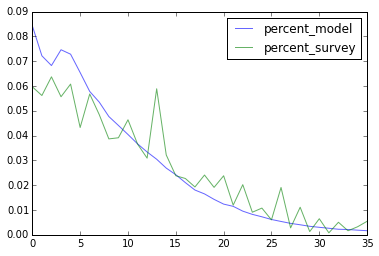

In [109]:
_df_merged[['percent_model','percent_survey']].plot(alpha=0.6)

# _df[['trexpfac']].plot(kind='bar')

# Average Trip Distance
Workers that work DO NOT work from home

In [110]:
# Non WFH Workers
df = pd.read_csv(os.path.join(relative_path,'agg','trip_distance_non_wfh.csv'))
df = df[df['pptyp'].isin(['Full-Time Worker','Part-Time Worker'])]
df = df[(df['dpurp'] == 'Work') & (df['dadtyp'].isin(['Other','Usual Workplace']))]
# df.groupby(['travdist_bin','']).sum()[['trexpfac']]
df_usual = df[df['dadtyp'] == 'Usual Workplace']
dist = (df_usual['trexpfac']*1.0*df_usual['travdist_bin']).sum()/df_usual['trexpfac'].sum()
print('Avg. distance to Usual Workplace: ' + str(dist))
df_other = df[df['dadtyp'] == 'Other']
dist = (df_other['trexpfac']*1.0*df_other['travdist_bin']).sum()/df_other['trexpfac'].sum()
print('Avg. distance to Other Workplace: ' + str(dist))
print('----------------------------------------')
# Non WFH Workers
df = pd.read_csv(os.path.join(relative_path,'agg','trip_distance_non_wfh.csv'))
df['wt_sum'] = df['trexpfac']*1.0*df['travdist_bin']

for purp in pd.unique(df['dpurp']):
    _df = df[df['dpurp'] == purp]
    result[purp] = _df['wt_sum'].sum()/_df['trexpfac'].sum()
    
_df_non_wfh = pd.DataFrame.from_dict(result, orient='index').reset_index()
_df_non_wfh.columns = ['Purpose','Workers at Non-Home Location']


Avg. distance to Usual Workplace: 6.76893574337
Avg. distance to Other Workplace: 4.55986302206
----------------------------------------


Only workers that work **from home**

In [111]:
# WFH Workers
df = pd.read_csv(os.path.join(relative_path,'agg','trip_distance_wfh.csv'))
df = df[(df['dpurp'] == 'Work') & (df['dadtyp'].isin(['Other','Usual Workplace']))]

df_other = df[df['dadtyp'] == 'Other']
dist = (df_other['trexpfac']*1.0*df_other['travdist_bin']).sum()/df_other['trexpfac'].sum()
print('Avg. distance to Other Workplace: ' + str(dist))
print('----------------------------------')
df = pd.read_csv(os.path.join(relative_path,'agg','trip_distance_wfh.csv'))
df['wt_sum'] = df['trexpfac']*1.0*df['travdist_bin']
for purp in pd.unique(df['dpurp']):
    _df = df[df['dpurp'] == purp]
    result[purp] = _df['wt_sum'].sum()/_df['trexpfac'].sum()
    
_df_wfh = pd.DataFrame.from_dict(result, orient='index')
_df_wfh = _df_wfh.reset_index()
_df_wfh.columns = ['Purpose','WFH Workers']

Avg. distance to Other Workplace: 13.2266697666
----------------------------------


In [112]:
# Non-Workers
df = pd.read_csv(os.path.join(relative_path,'agg','trip_distance_non_wfh.csv'))
df = df[-df['pptyp'].isin(['Full-Time Worker','Part-Time Worker'])]
df = df[(df['dpurp'] == 'Work') & (df['dadtyp'].isin(['Other','Usual Workplace']))]

# Non-Workers
df = pd.read_csv(os.path.join(relative_path,'agg','trip_distance_non_wfh.csv'))
df['wt_sum'] = df['trexpfac']*1.0*df['travdist_bin']
result = {}
for purp in pd.unique(df['dpurp']):
    _df = df[df['dpurp'] == purp]
    result[purp] = _df['wt_sum'].sum()/_df['trexpfac'].sum()
    
_df_non_worker = pd.DataFrame.from_dict(result, orient='index')
_df_non_worker = _df_non_worker.reset_index()
_df_non_worker.columns = ['Purpose','Non-Workers']


Average Trip Distance by Purpose and Worker/Person Type

In [113]:
_df = pd.merge(_df_non_wfh, _df_wfh).merge(_df_non_worker)

In [114]:
_df

,Purpose,Workers at Non-Home Location,WFH Workers,Non-Workers
0,Shop,3.1495,4.0897,3.1495
1,School,2.4338,4.7990,2.4338
2,Work,6.2927,13.2262,6.2927
3,Meal,2.3167,4.1553,2.3167
4,Change Mode Inserted Purpose,6.6284,11.7804,6.6284
5,Escort,4.3594,5.4006,4.3594
6,Social,3.4199,3.8736,3.4199
7,None/Home,4.4876,7.6091,4.4876
8,Personal Business,3.9412,4.6536,3.9412


# Commute Tour Distance by Mode
All Workers

In [115]:
df = pd.read_csv(os.path.join(relative_path,'agg','tour_distance.csv'))

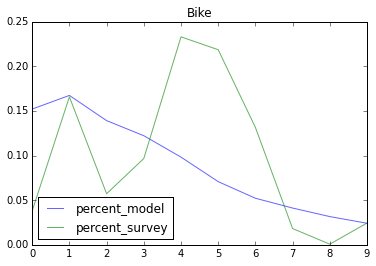

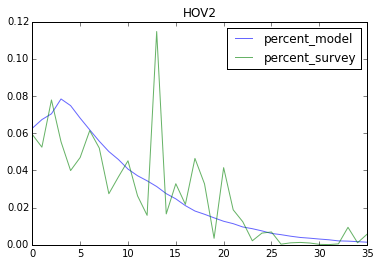

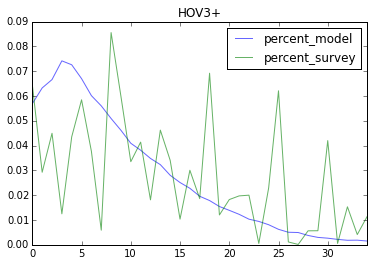

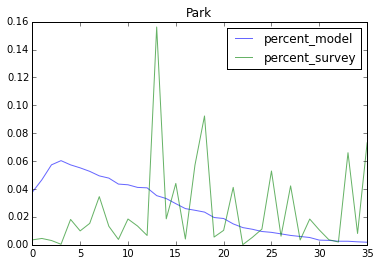

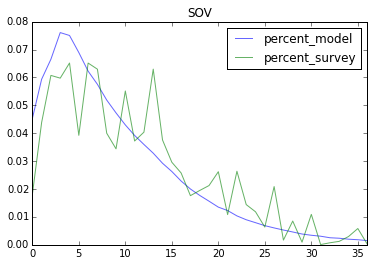

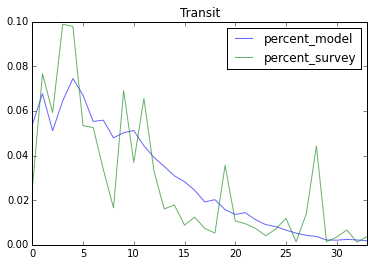

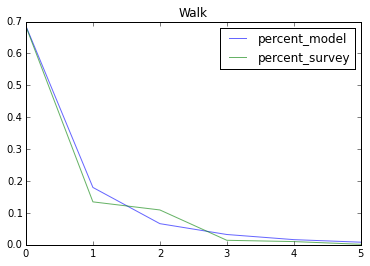

In [116]:
df = pd.read_csv(os.path.join(relative_path,'agg','tour_distance.csv'))
df = df[df['pdpurp'] == 'Work']
df = df[df['tmodetp'] != "-1"]

for mode in df['tmodetp'].unique():
    _df = df[df['tmodetp'] == mode]
    
    _df = _df.groupby('tautodist_bin').sum()[['toexpfac']].reset_index()

    _df['percent'] = _df['toexpfac']/_df['toexpfac'].sum()
    _df['cumulative_percent'] = _df['percent'].cumsum()

    # remove records that are outside 99% of records
    _df = _df[_df['cumulative_percent'] <= 0.99]
    
    _df_survey = df_survey[df_survey['tmodetp'] == mode]
    _df_survey = _df_survey.groupby('tautodist_bin').sum()[['toexpfac']].reset_index()

    _df_survey['percent'] = _df_survey['toexpfac']/_df_survey['toexpfac'].sum()
    _df_survey['cumulative_percent'] = _df_survey['percent'].cumsum()

    # remove records that are outside 99% of records
    _df_survey = _df_survey[_df_survey['cumulative_percent'] <= 0.99]
    
    _df_merged = _df.merge(_df_survey, on='tautodist_bin', suffixes=['_model','_survey'])
    _df_merged[['percent_model','percent_survey']].plot(alpha=0.6, title=mode)
    